In [1]:
from pandas_datareader import data as web
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import os

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
#Grabbing the data from Yahoo-API
start = dt.datetime(2016,1,1)
end = dt.datetime(2019,12,31)

df = web.DataReader("AAPL", "yahoo", start, end)

In [ ]:
#Or read the csv file from disk
df = pd.read_csv("stock_data.csv", sep=",", index_col = 0) #set "Date" column as index and convert to datetime
df.index = pd.to_datetime(df.index)

In [ ]:
#Sanity Checks
df.head()

In [ ]:
df.tail()

In [ ]:
df["Close"]["2016-01-05"]

In [ ]:
df["Close"][1]

In [ ]:
#Save data as csv
df.to_csv("stock_data.csv", sep=",")

In [ ]:
#Data cleaning and crafting SMAs
df.dropna(inplace=True)
df["100ma"] = df["Adj Close"].rolling(window = 100, min_periods = 0).mean()
df["25ma"] = df["Adj Close"].rolling(window = 25, min_periods = 0).mean()

#Plotting
df["Adj Close"].plot()
df["100ma"].plot()
df["25ma"].plot()
style.use("seaborn")
plt.grid(True)
plt.show()

In [ ]:
df.head()

In [ ]:
df["ChangePct"] = ((df["Close"] - df["Open"]) / df["Open"]) * 100

In [ ]:
df["ChangePts"] = (df["Close"] - df["Open"])

In [ ]:
df["VolatilityPct"] = (df["High"] - df["Low"]) / df["Close"] * 100

In [ ]:
df.head()

In [ ]:
# Adding Subplots
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=4, colspan=1) # window size, start position, plot size (4 x 1)
ax2 = plt.subplot2grid((8,1), (4,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax3 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax4 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)

ax1.plot(df.index, df["Adj Close"])
ax1.plot(df.index, df["100ma"])
ax2.plot(df.index, df["ChangePts"])
ax3.bar(df.index, df["VolatilityPct"])
ax4.plot(df.index, df["ChangePct"])

### Candlestick Charts

In [ ]:
df_ohlc = df["Adj Close"].resample("10D").ohlc()

In [ ]:
df_ohlc.head()

In [ ]:
df_volume = df["Volume"].resample("10D").sum()

In [ ]:
df_volume.head()

In [ ]:
df_ohlc.reset_index(inplace=True) #mpl_finance can't work with datetime, therefore: create empty index
df_ohlc["Date"] = df_ohlc["Date"].map(mdates.date2num) # and map each real Date to a numeric Date number

In [ ]:
df_ohlc.head()

In [ ]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1) # window size, start position, plot size (5 x 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax1.xaxis_date() # plots date on x-axis 
candlestick_ohlc(ax1, df_ohlc.values, width=8, colorup="g", colordown="r") #creates the candlesticks

ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values) # converted dates as index, volume as y-axis
ax1.grid(True, color="lightgray") #changes gridcolor
plt.show()

### Webscraping

In [2]:
#Load ticker names
import bs4 as bs
import requests
import pickle

def lade_sp500_ticker():
    response = requests.get("https://en.wikipedia.org/wiki/list_of_S%26P_500_companies") #get sourcecode
    soup = bs.BeautifulSoup(response.text, "lxml")
    
    tabelle = soup.find("table")
    tickers = []
    
    for reihe in tabelle.findAll("tr")[1:]:
        ticker = reihe.findAll("td")[0].text.rstrip("\n")
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f: #serializes ticker data into pickle file
        pickle.dump(tickers, f)
    return tickers


#lade_sp500_ticker()

In [3]:
#Load prices from yahoo
def lade_preise_von_yahoo(ticker_neuladen=False):
    if ticker_neuladen:
        tickers = lade_sp500_ticker() #loads ticker names again from wikipedia
    else:
        with open ("sp500tickers", "rb") as f: #grabs existing ticker names from local folder
            tickers = pickle.load(f)

    if not os.path.exists("kursdaten"): #creates new folder if not already existing
        os.makedirs("kursdaten")
    
    start = dt.datetime(2010,1,1)
    end = dt.datetime(2019,12,31)

    for ticker in tickers:
        if not os.path.exists("kursdaten/{}.csv".format(ticker)):
            print("{} wird geladen...".format(ticker))
            try:
                df = web.DataReader(ticker, "yahoo", start, end)
                df.to_csv("kursdaten/{}.csv".format(ticker))
            except:
                print("{} nicht vorhanden.".format(ticker))
        else:
            print("{} bereits vorhanden!".format(ticker))


In [8]:
#combine all csv into one big file
def daten_kompilieren():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame()
    
    print("Daten werden kompiliert...")
    for ticker in tickers:
        try:
            df = pd.read_csv("kursdaten/{}.csv".format(ticker))
            df.set_index("Date", inplace=True)
        
            df.rename(columns = {"Adj Close": ticker}, inplace=True)
            df.drop(["Open","High","Low","Close","Volume"], 1, inplace=True)
        except:
            pass
        if main_df.empty:
            main_df = df
        else:
            try:
                main_df = main_df.join(df, how="outer")
            except:
                pass
            
    main_df.to_csv("sp500_daten.csv")
    print("Daten kompiliert.")

In [9]:
#lade_preise_von_yahoo(ticker_neuladen=True)
daten_kompilieren()

Daten werden kompiliert...
Daten kompiliert.


### Visuals

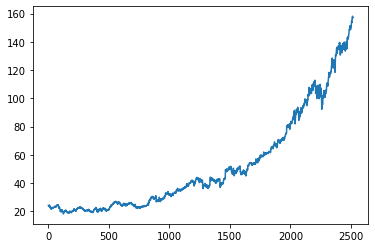

In [11]:
sp500 = pd.read_csv("sp500_daten.csv")
sp500["MSFT"].plot()
plt.show()

In [13]:
korrelation = sp500.corr()
print(korrelation)

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.822141  0.911094  0.825415  0.891598  0.929977  0.826965   
ABT   0.822141  1.000000  0.789407  0.842906  0.966075  0.805016  0.967697   
ABBV  0.911094  0.789407  1.000000  0.878404  0.862537  0.904558  0.858206   
ABMD  0.825415  0.842906  0.878404  1.000000  0.875561  0.895261  0.915947   
ACN   0.891598  0.966075  0.862537  0.875561  1.000000  0.898829  0.970270   
...        ...       ...       ...       ...       ...       ...       ...   
YUM   0.840670  0.975739  0.794911  0.838859  0.974264  0.830900  0.957171   
ZBRA  0.775197  0.975091  0.774365  0.833410  0.934803  0.772920  0.962316   
ZBH   0.914795  0.851013  0.730304  0.695784  0.885174  0.820399  0.799144   
ZION  0.897179  0.865129  0.906291  0.891769  0.909198  0.918842  0.914727   
ZTS   0.689016  0.976971  0.806100  0.800460  0.975624  0.741559  0.976433   

           AMD       AAP       AES  ...      WYNN       XEL    